# GoogleNet - WITHOUT Transfer Learning
#### Shreyas Kumar - 18481693

We're using Kaggle, so we're getting the entire dataset from Kaggle.

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = KAGGLE_USERNAME
os.environ['KAGGLE_KEY'] = API_KEY
!rm -r /content/sample_data
!kaggle datasets download -d alessiocorrado99/animals10
!unzip animals10.zip
!rm -r /content/animals10.zip
!rm -r /content/translate.py

Streaming output truncated to the last 5000 lines.
  inflating: raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ragno/OIP-Mis0lJf3

All the necessary imports.

In [3]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter
from sklearn.manifold import TSNE
from torch.optim.lr_scheduler import StepLR
import time

### Transformations
We're transforming the images to 224x224, as that's the input size for GoogleNet. We're also normalizing the images.
#### Data Augmentation
We're using data augmentation to increase the size of the dataset. We're using the following transformations:
- RandomHorizontalFlip
- RandomRotation
- RandomResizedCrop
- ColorJitter
- RandomAffine

In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ColorJitter()
])

full_dataset = datasets.ImageFolder('/content/raw-img', transform=transform)
class_counts = {class_name: 0 for class_name in full_dataset.classes}
for _, index in full_dataset.samples:
    class_name = full_dataset.classes[index]
    class_counts[class_name] += 1
print("Total number of classes:", len(full_dataset.classes))
print("Class names:", full_dataset.classes)
print("Number of images per class:")
for class_name, count in class_counts.items():
    print(f" - {class_name}: {count}")

Total number of classes: 10
Class names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Number of images per class:
 - cane: 4863
 - cavallo: 2623
 - elefante: 1446
 - farfalla: 2112
 - gallina: 3098
 - gatto: 1668
 - mucca: 1866
 - pecora: 1820
 - ragno: 4821
 - scoiattolo: 1862


After defining the transformations, we're loading the dataset.
We're first determining the split size of the dataset, into training, testing and validation. We're using 80% for training, 10% for testing and 10% for validation, since that seems to be a better cut for us.

In [5]:
train_size = int(0.8 * len(full_dataset))
test_validation_size = len(full_dataset) - train_size
validation_size = test_validation_size // 2
test_size = test_validation_size - validation_size

train_dataset, test_validation_dataset = random_split(full_dataset, [train_size, test_validation_size])
validation_dataset, test_dataset = random_split(test_validation_dataset, [validation_size, test_size])

print("Size of the entire Dataset: ", len(full_dataset))
print("Size of the training Dataset: ", len(train_dataset))
print("Size of the validation Dataset: ", len(validation_dataset))
print("Size of the test Dataset: ", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Size of the entire Dataset:  26179
Size of the training Dataset:  20943
Size of the validation Dataset:  2618
Size of the test Dataset:  2618


After getting the dataset, and dividing them into the response dataloaders with batch size of 32, shuffled.
We initialize the model, and define the loss function and optimizer. We're using CrossEntropyLoss and Adam optimizer.

In [6]:
googlenet = models.googlenet(pretrained=False, aux_logits=False)
googlenet.fc = torch.nn.Linear(googlenet.fc.in_features, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(googlenet.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
writer = SummaryWriter()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Here, the training section begins. Let me first define the first 4 variables:
- Patience: The number of epochs to wait before stopping the training if the validation loss doesn't decrease.
- Best Validation Loss: The best validation loss we've seen so far.
- Patience Counter: The number of epochs we've waited so far.
- Epochs: The number of epochs we're training for.
After this the training loop begins, in which the model is training.
We're printing ALL the metrics (Training Loss, Validation Loss, Training Accuracy, Validation Accuracy) after every epoch, so that we know where we're heading with each epoch.

In [7]:
patience = 5
best_val_loss = np.inf
patience_counter = 0
epochs = 25
for epoch in range(epochs):
    epoch_start_time = time.time()
    train_loss = 0.0
    train_correct = 0
    total_train = 0
    googlenet.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / total_train
    writer.add_scalar('Loss/Train', train_loss / len(train_loader), epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)

    googlenet.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / total_val
    writer.add_scalar('Loss/Validation', val_loss / len(validation_loader), epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

    if val_loss / len(validation_loader) < best_val_loss:
        best_val_loss = val_loss / len(validation_loader)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    scheduler.step()
    print(f"Epoch {epoch+1}: Train Loss: {train_loss / len(train_loader):.4f}, "
      f"Train Accuracy: {train_accuracy:.2f}%, "
      f"Val Loss: {val_loss / len(validation_loader):.4f}, "
      f"Val Accuracy: {val_accuracy:.2f}%")
writer.close()

Epoch 1: Train Loss: 1.6000, Train Accuracy: 44.99%, Val Loss: 1.3725, Val Accuracy: 53.78%
Epoch 2: Train Loss: 1.1044, Train Accuracy: 62.63%, Val Loss: 1.2102, Val Accuracy: 59.51%
Epoch 3: Train Loss: 0.8848, Train Accuracy: 70.16%, Val Loss: 0.9184, Val Accuracy: 69.67%
Epoch 4: Train Loss: 0.7495, Train Accuracy: 75.28%, Val Loss: 0.8007, Val Accuracy: 73.07%
Epoch 5: Train Loss: 0.6574, Train Accuracy: 78.26%, Val Loss: 0.6640, Val Accuracy: 77.39%
Epoch 6: Train Loss: 0.4583, Train Accuracy: 85.19%, Val Loss: 0.4495, Val Accuracy: 85.10%
Epoch 7: Train Loss: 0.4015, Train Accuracy: 87.17%, Val Loss: 0.4210, Val Accuracy: 85.98%
Epoch 8: Train Loss: 0.3778, Train Accuracy: 87.96%, Val Loss: 0.4159, Val Accuracy: 85.79%
Epoch 9: Train Loss: 0.3591, Train Accuracy: 88.42%, Val Loss: 0.3910, Val Accuracy: 86.86%
Epoch 10: Train Loss: 0.3390, Train Accuracy: 89.18%, Val Loss: 0.3852, Val Accuracy: 87.32%
Epoch 11: Train Loss: 0.3100, Train Accuracy: 90.29%, Val Loss: 0.3736, Val Acc

I also have a function to plot the metrics, so that we can visualize the training process.
After saving all the metrics in a runs file, I extract it and plot the metrics.
This is important, since it helps us understand the training process better.
It helps us visualise, and understand things better.

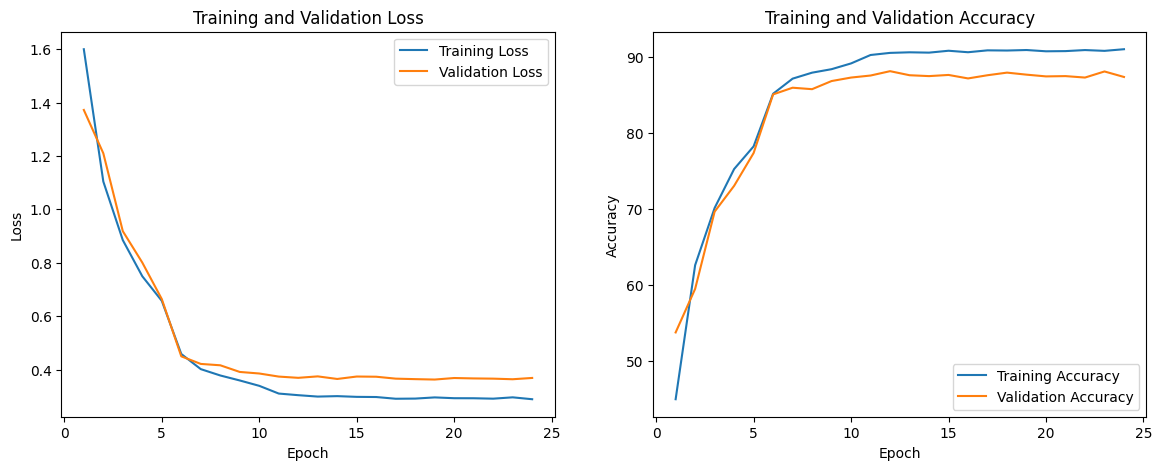

In [9]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = '/content/runs/Apr05_07-33-20_642b1baa7b61'
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

def extract_scalar(event_acc, tag):
    if tag in event_acc.Tags()['scalars']:
        return [scalar.value for scalar in event_acc.Scalars(tag)]
    else:
        return []

train_losses = extract_scalar(event_acc, 'Loss/Train')
train_accuracies = extract_scalar(event_acc, 'Accuracy/Train')
val_losses = extract_scalar(event_acc, 'Loss/Validation')
val_accuracies = extract_scalar(event_acc, 'Accuracy/Validation')
test_losses = extract_scalar(event_acc, 'Loss/Test')
test_accuracies = extract_scalar(event_acc, 'Accuracy/Test')
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
if test_losses:
    plt.axhline(y=test_losses[0], color='r', linestyle='-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
if test_accuracies:
    plt.axhline(y=test_accuracies[0], color='r', linestyle='-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

Okay now comes the important part.
Let us breakdown whats happening in the graphs first.
I plotted these graphs multiple times here, so that I understand what's happening.

First question I had was: Is the model overfitting?
Training loss is decreasing, as well as the validation loss. The training accuracy is increasing, and the validation accuracy is also increasing (and sort of stabalises after a point).
Because of this I couldn't completely conclude if the model is overfitting.

Second question I had was: Is the model learning anything?
- The training loss is decreasing, and the validation loss is also decreasing. This is a clear sign that the model is learning something. The model is generalizing well on the validation data.



Test Accuracy: 87.05%


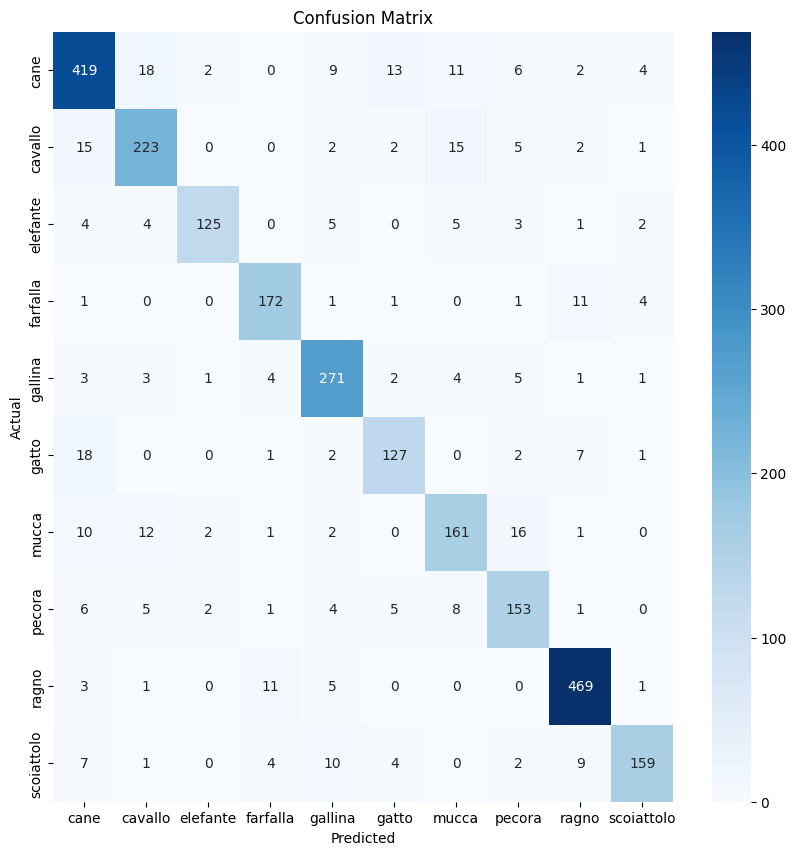

In [10]:
from sklearn.metrics import accuracy_score
googlenet.eval()
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = googlenet(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\033[1mTest Accuracy: {accuracy * 100:.2f}%\033[0m")
conf_mat = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, target_names=full_dataset.classes, output_dict=True)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
print("\n\033[1mClassification Report:\033[0m")
print(classification_report(true_labels, predicted_labels, target_names=full_dataset.classes))


Classification Report:
              precision    recall  f1-score   support

        cane       0.86      0.87      0.86       484
     cavallo       0.84      0.84      0.84       265
    elefante       0.95      0.84      0.89       149
    farfalla       0.89      0.90      0.89       191
     gallina       0.87      0.92      0.89       295
       gatto       0.82      0.80      0.81       158
       mucca       0.79      0.79      0.79       205
      pecora       0.79      0.83      0.81       185
       ragno       0.93      0.96      0.94       490
  scoiattolo       0.92      0.81      0.86       196

    accuracy                           0.87      2618
   macro avg       0.87      0.85      0.86      2618
weighted avg       0.87      0.87      0.87      2618



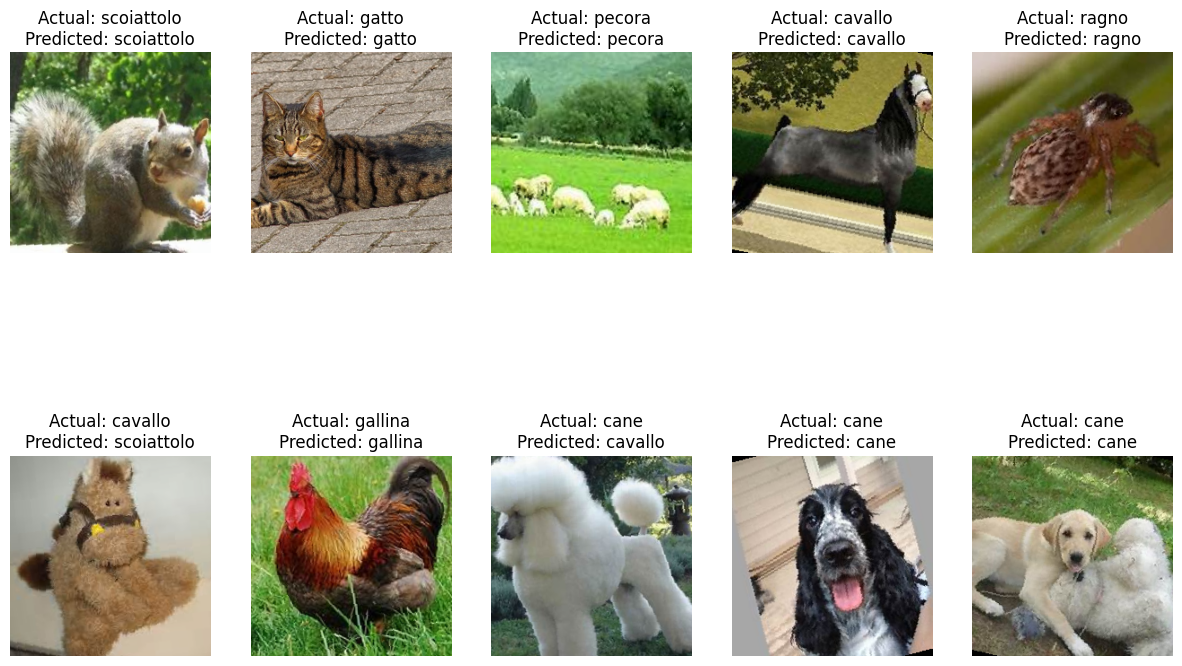

In [12]:
def imshow_with_labels(images, labels, predicted_labels):
    """Display images with labels."""
    fig, axs = plt.subplots(2, 5, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.1)
    axs = axs.flatten()
    for i in range(len(images)):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axs[i].imshow(img)
        axs[i].set_title(f'Actual: {full_dataset.classes[labels[i]]}\nPredicted: {predicted_labels[i]}')
        axs[i].axis('off')
    plt.show()
images, labels = next(iter(test_loader))
num_images = 10
images_to_show = images[:num_images]
labels_to_show = labels[:num_images]
images_to_show = images_to_show.to(device)
outputs = googlenet(images_to_show)
_, preds = torch.max(outputs, 1)
predicted_labels = [full_dataset.classes[pred] for pred in preds]
imshow_with_labels(images_to_show, labels_to_show, predicted_labels)

In [13]:
import torch

# Set the model to evaluation mode
googlenet.eval()

# Save the entire model
torch.save(googlenet, 'wildlife_classifier_model.pth')

# Save class names
import json
class_names = full_dataset.classes
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

print("Model and class names saved successfully!")

Model and class names saved successfully!
